In [222]:
import os
os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

init_notebook_mode(connected=True)

Device: cuda


In [243]:
model = HookedTransformer.from_pretrained('gpt2', device=device)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2 into HookedTransformer


In [362]:
clean_prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
    "name": "Davide",
    "age": "20",
    "city": "Rome"
}

My name is Paul and I live in San Francisco. I've just turned 12.
{'''

corrupted_prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": "20"
}

Hi, I'm Laura and I'm 25.
{
    "name": "'''

#My name is Paul and I've just turned 12.
#{
#    "name": "Paul",
#    "age": 12
#} Hi, I'm Laura and I'm 25.

clean_prompt = '''Davide is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities":'''

### Patching

In [350]:
from transformer_lens.utils import test_prompt

test_prompt(clean_prompt, 'Sarah', model)

Tokenized prompt: ['<|endoftext|>', 'D', 'av', 'ide', ' is', ' a', ' student', ' at', ' Stanford', ' and', ' Mary', ' works', ' at', ' McDonald', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'ent', 'ities', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 0', ',', ' "', 'name', '":', ' "', 'D', 'av', 'ide', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 1', ',', ' "', 'name', '":', ' "', 'Stan', 'ford', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 2', ',', ' "', 'name', '":', ' "', 'Mary', '"},', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '":', ' 3', ',', ' "', 'name', '":', ' "', 'Mc', 'Donald', '"},', '\n', ' ', ' ', ' ', ' ],', '\n', ' ', ' ', ' ', ' "', 'relations', '":', ' [', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '_', 'a', '":', ' 0', ',', ' "', 'id', '_', 'b', '":', ' 1', ',', ' "', 'relation', '":', ' "', 'study', '"}', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' {"', 'id', '_', 'a', 

Performance on answer token:
Rank: 2817     Logit:  3.21 Prob:  0.00% Token: | Sarah|

Top 0th token. Logit: 15.80 Prob: 72.93% Token: |
|
Top 1th token. Logit: 14.09 Prob: 13.22% Token: | |
Top 2th token. Logit: 12.22 Prob:  2.04% Token: | }|
Top 3th token. Logit: 12.13 Prob:  1.86% Token: |  |
Top 4th token. Logit: 11.68 Prob:  1.18% Token: | "|
Top 5th token. Logit: 10.89 Prob:  0.54% Token: | {|
Top 6th token. Logit: 10.76 Prob:  0.47% Token: |<|endoftext|>|
Top 7th token. Logit: 10.58 Prob:  0.39% Token: | \|
Top 8th token. Logit: 10.35 Prob:  0.31% Token: | |
Top 9th token. Logit: 10.28 Prob:  0.29% Token: | id|


Ranks of the answer tokens: [(' Sarah', 2817)]

In [305]:
import os
import sys

current_dir = os.getcwd()
atp_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(atp_dir)

from atp import Patching

patching = Patching(model, 'atp')

In [306]:
a_clean = 'Sarah'
a_corr = 'Laura'

patching.patching(clean_prompt, a_clean, corrupted_prompt, a_corr, component='attn_all')

Clean logit difference: 7.589
Corrupted logit difference: -7.148
Patching...


In [307]:
fig = patching.plot()
fig.write_html("fig.html")

In [335]:
def head_modifier_hook(x, hook, head_id, lam=1.2):
    x[:, -1, head_id, :] = lam * x[:, -1, head_id, :]
    return x

In [342]:
test_prompt(clean_prompt, 'Sarah', model)

Tokenized prompt: ['<|endoftext|>', 'I', "'m", ' Dav', 'ide', ',', ' I', "'m", ' 20', ' years', ' old', ' and', ' I', ' live', ' in', ' Rome', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'name', '":', ' "', 'D', 'av', 'ide', '",', '\n', ' ', ' ', ' ', ' "', 'age', '":', ' "', '20', '",', '\n', ' ', ' ', ' ', ' "', 'city', '":', ' "', 'R', 'ome', '"', '\n', '}', '\n', '\n', 'My', ' name', ' is', ' Paul', ' and', ' I', ' live', ' in', ' San', ' Francisco', '.', ' I', "'ve", ' just', ' turned', ' 12', '.', '\n', '{']
Tokenized answer: [' Sarah']


Performance on answer token:
Rank: 4269     Logit:  3.01 Prob:  0.00% Token: | Sarah|

Top 0th token. Logit: 14.79 Prob: 44.28% Token: | |
Top 1th token. Logit: 14.43 Prob: 30.95% Token: |
|
Top 2th token. Logit: 12.43 Prob:  4.20% Token: | }|
Top 3th token. Logit: 12.37 Prob:  3.94% Token: |  |
Top 4th token. Logit: 11.61 Prob:  1.85% Token: | "|
Top 5th token. Logit: 10.48 Prob:  0.60% Token: | |
Top 6th token. Logit: 10.10 Prob:  0.41% Token: | {|
Top 7th token. Logit: 10.00 Prob:  0.37% Token: | I|
Top 8th token. Logit:  9.95 Prob:  0.35% Token: |<|endoftext|>|
Top 9th token. Logit:  9.90 Prob:  0.33% Token: |I|


Ranks of the answer tokens: [(' Sarah', 4269)]

In [363]:
heads = [(8, 11), (9, 6), (9, 9), (10, 0), (10, 1), (10, 10)]
top_token_probas = []
second_token_probas = []
lams = np.linspace(1, 5, 50)

for lam in tqdm(lams):
    with torch.no_grad():
        vals, idxs = model.run_with_hooks(
            model.to_tokens(clean_prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1).topk(10, dim=-1)

        top_token_probas.append(vals[0, -1, 0].item())
        second_token_probas.append(vals[0, -1, 1].item())

100%|██████████| 50/50 [00:01<00:00, 34.06it/s]


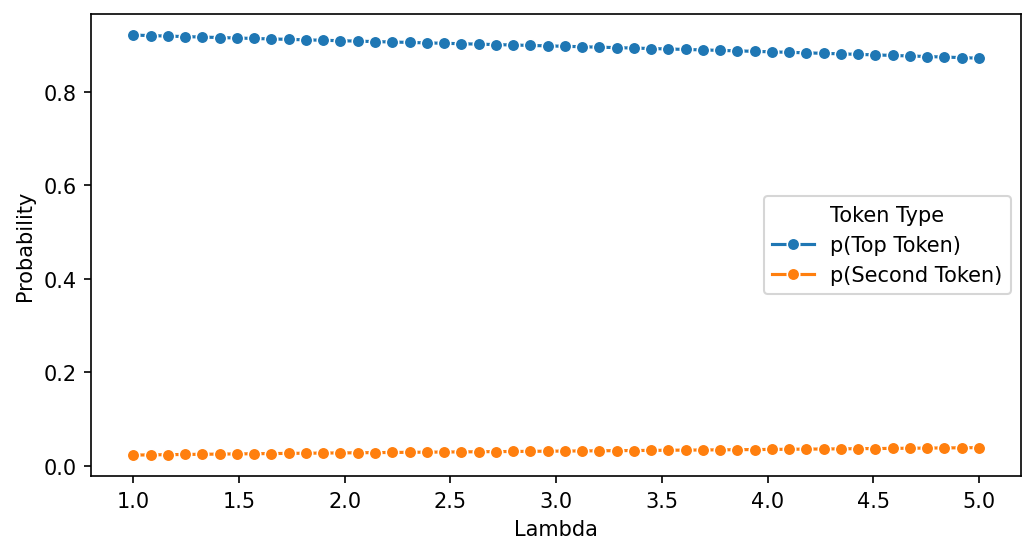

In [364]:
import pandas as pd
fig = plt.figure(figsize=(8, 4), dpi=150)
data = pd.DataFrame({
    'Lambda': lams,
    'p(Top Token)': top_token_probas,
    'p(Second Token)': second_token_probas,
}).melt(id_vars='Lambda', var_name='Token Type', value_name='Probability')
ax = sns.lineplot(data=data, x='Lambda', y='Probability', hue='Token Type', marker='o')

In [365]:
heads = [(8, 11), (9, 6), (9, 9), (10, 0), (10, 1), (10, 10)]
lam = 5

tokens = model.to_tokens(clean_prompt)
max_new_tokens = 32

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 32/32 [00:01<00:00, 30.69it/s]

<|endoftext|>Davide is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [

{

"id": 1, "name": "John",

"id": 2, "name": "John"},




### AtP

In [355]:
patching = Patching(model, 'atp')

In [6]:
x_clean = clean_prompt
x_corr = corrupted_prompt

a_clean = 'Sarah'
a_corr = 'Laura'

patching.patching(x_clean, a_clean, x_corr, a_corr, component='attn_all')

Clean logit difference: 11.632
Corrupted logit difference: -10.022
Patching...


In [7]:
fig = patching.plot()
fig.write_html("fig.html")

Promoting heads: L8H11, L9H6, L9H9, L10H0, L10H1, L10H10

Suppression heads: L10H7, L10H11

In [88]:
prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": 20
}

I'm Paul and I'm 12 years old.
{
    "name": "Paul",
    "age": 12
}'''

prompt = "John and Mary went to the store, then John gave a bottle of milk to"

In [74]:
def logits_diff(logits, ans, topk=5):
    top_tokens = logits[0, -1].topk(topk).indices.tolist()
    if isinstance(ans, str):
        ans = model.to_single_token(ans)

    if ans in top_tokens:
        top_tokens.remove(ans)
        
    return logits[0, -1, ans] - logits[0, -1, top_tokens].mean(-1)
    
def get_cache_fwd_and_bwd(tokens, ans):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        value = logits_diff(model(tokens), ans, topk=10)
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [89]:
tokens = model.to_tokens(prompt)
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'John'),
 (2, ' and'),
 (3, ' Mary'),
 (4, ' went'),
 (5, ' to'),
 (6, ' the'),
 (7, ' store'),
 (8, ','),
 (9, ' then'),
 (10, ' John'),
 (11, ' gave'),
 (12, ' a'),
 (13, ' bottle'),
 (14, ' of'),
 (15, ' milk'),
 (16, ' to')]

In [76]:
import einops
from tqdm import tqdm

first_output_token_id = 17

patch = torch.zeros(144, len(tokens[0]) - first_output_token_id)

for i in tqdm(range(first_output_token_id, len(tokens[0]))):
    _, cache, grad_cache = get_cache_fwd_and_bwd(tokens[:, :i], tokens[0, i])

    act = cache.stack_head_results(-1)
    grad_act = grad_cache.stack_head_results(-1)

    patch[:, i-first_output_token_id] = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos",
                "sum",
            )[:, -1]

100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


In [62]:
patch = patch_1 - patch_2
patch[patch.abs() < 0.2] = 0

In [77]:
import plotly.express as px
ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(model.to_str_tokens(prompt)[first_output_token_id:])]

fig = px.imshow(
    patch.cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-1, zmax=1, aspect='auto'
)
fig.write_html("fig.html")

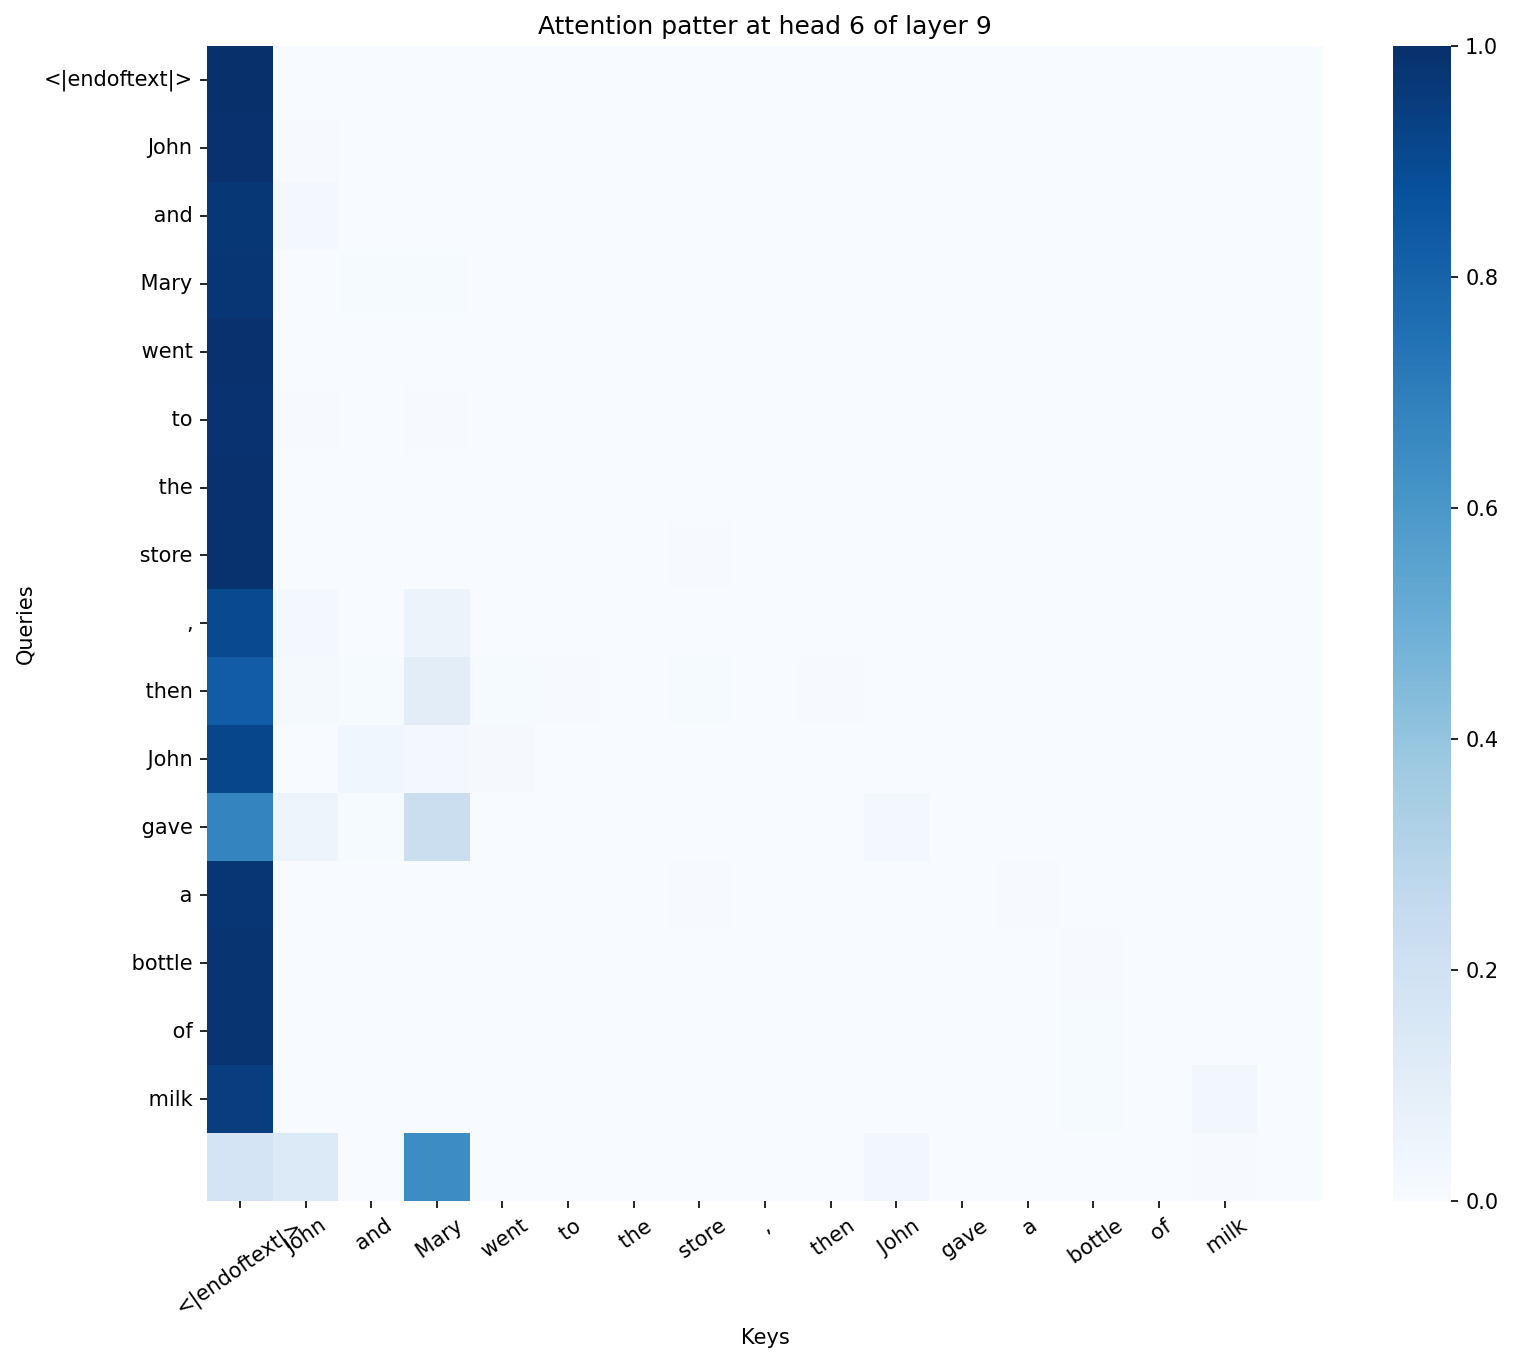

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
layer_id = 9
head_id = 6

data = cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()
labels = model.to_str_tokens(prompt)[:-1]
# Set up the matplotlib figure
plt.figure(figsize=(12, 10), dpi=150)

# Draw the heatmap
ax = sns.heatmap(data, cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(labels))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title(f'Attention patter at head {head_id} of layer {layer_id}')
plt.xlabel('Keys')
plt.ylabel('Queries')

# Show the plot
plt.show()

## SAEs

In [80]:
from huggingface_hub import snapshot_download

REPO_ID = "jbloom/GPT2-Small-SAEs-Reformatted"
path = snapshot_download(repo_id=REPO_ID)

Fetching 41 files:   0%|          | 0/41 [00:00<?, ?it/s]

In [82]:
from sae_lens import LMSparseAutoencoderSessionloader
from tqdm import tqdm
import os

saes = []

for l in tqdm(range(model.cfg.n_layers)):
    model, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_pretrained_sae(
        path = os.path.join(path, f"blocks.{l}.hook_resid_pre"), device=device
    )
    sae_group.eval()
    saes.append(sae_group[f'blocks.{l}.hook_resid_pre'])

  0%|          | 0/12 [00:00<?, ?it/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


  8%|▊         | 1/12 [00:05<01:04,  5.89s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 17%|█▋        | 2/12 [00:29<02:43, 16.35s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 25%|██▌       | 3/12 [00:39<02:00, 13.37s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 33%|███▎      | 4/12 [00:45<01:24, 10.59s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 42%|████▏     | 5/12 [01:05<01:37, 13.90s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 50%|█████     | 6/12 [01:18<01:22, 13.70s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 58%|█████▊    | 7/12 [01:24<00:55, 11.05s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 67%|██████▋   | 8/12 [01:30<00:37,  9.47s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 75%|███████▌  | 9/12 [01:36<00:24,  8.30s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 83%|████████▎ | 10/12 [01:42<00:15,  7.74s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 92%|█████████▏| 11/12 [01:48<00:07,  7.25s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


100%|██████████| 12/12 [03:58<00:00, 19.86s/it]


In [172]:
sae_cache = {}
sae_grad_cache = {}

def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    
    # Function to capture the gradient
    def capture_grad(grad):
        sae_grad_cache[hook.name] = grad.clone()

    # Register the hook to capture the gradient
    if f_act.requires_grad:
        f_act.register_hook(capture_grad)
    
    sae_cache[hook.name] = f_act.detach()
    return sae_out

In [195]:
from functools import partial

component = 'resid_pre'

out = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    utils.get_act_name(component, layer_id),
                    partial(reconstr_hook, sae=saes[layer_id]),
                )
            for layer_id in range(model.cfg.n_layers)]
        ).log_softmax(-1)

ans = model.to_single_token(' John')
loss = - out[0, -1, ans]

loss.backward()

In [196]:
act = torch.stack(list(sae_cache.values()))
grad_act = torch.stack(list(sae_grad_cache.values()))

patch = einops.reduce(
                grad_act, # *  act,
                "component batch pos d_model -> component pos d_model",
                "sum",
            )

In [218]:
vals, idxs = patch.mean(1).topk(10, dim=-1)

In [220]:
idxs

tensor([[ 9605, 18058,  7804, 17313, 16201, 11473,  4310,  9587,  5052, 14589],
        [ 8879, 23151,  3987,  8277,  3731, 16536,  8802,  4699,  9002,  5021],
        [18298,    47,  3354, 24502,  4260, 14826, 21381,  6626,  3032, 20655],
        [21978, 18920,  2010, 16498, 13643,  1259, 22231,  4571,  7771, 23099],
        [16087, 20434, 16715, 14797, 20387,  2516, 15879,  6552,  7979,  5682],
        [ 5295, 13063, 17733, 22578, 23870, 19012,  4947, 24235, 18854, 13496],
        [ 5343,   970, 18424, 11438, 13646, 11765,  4622, 18924, 15842, 10520],
        [23261, 14548, 23496,  6993, 20789, 18579, 18766, 24482, 20386, 20186],
        [20373, 20342, 24421,  6980,  6026,  2659, 12804, 19885, 23616, 10226],
        [11548,  5007,  5908,  5889, 15079, 19757, 15038, 10633, 23706,  8168],
        [20964, 15797,  2159,  9553, 18292,  9564, 22951,  9639,  9347, 10883],
        [11070, 21122,  1622, 17396, 14100, 14909, 10327, 14110, 12301, 21858]],
       device='cuda:0')

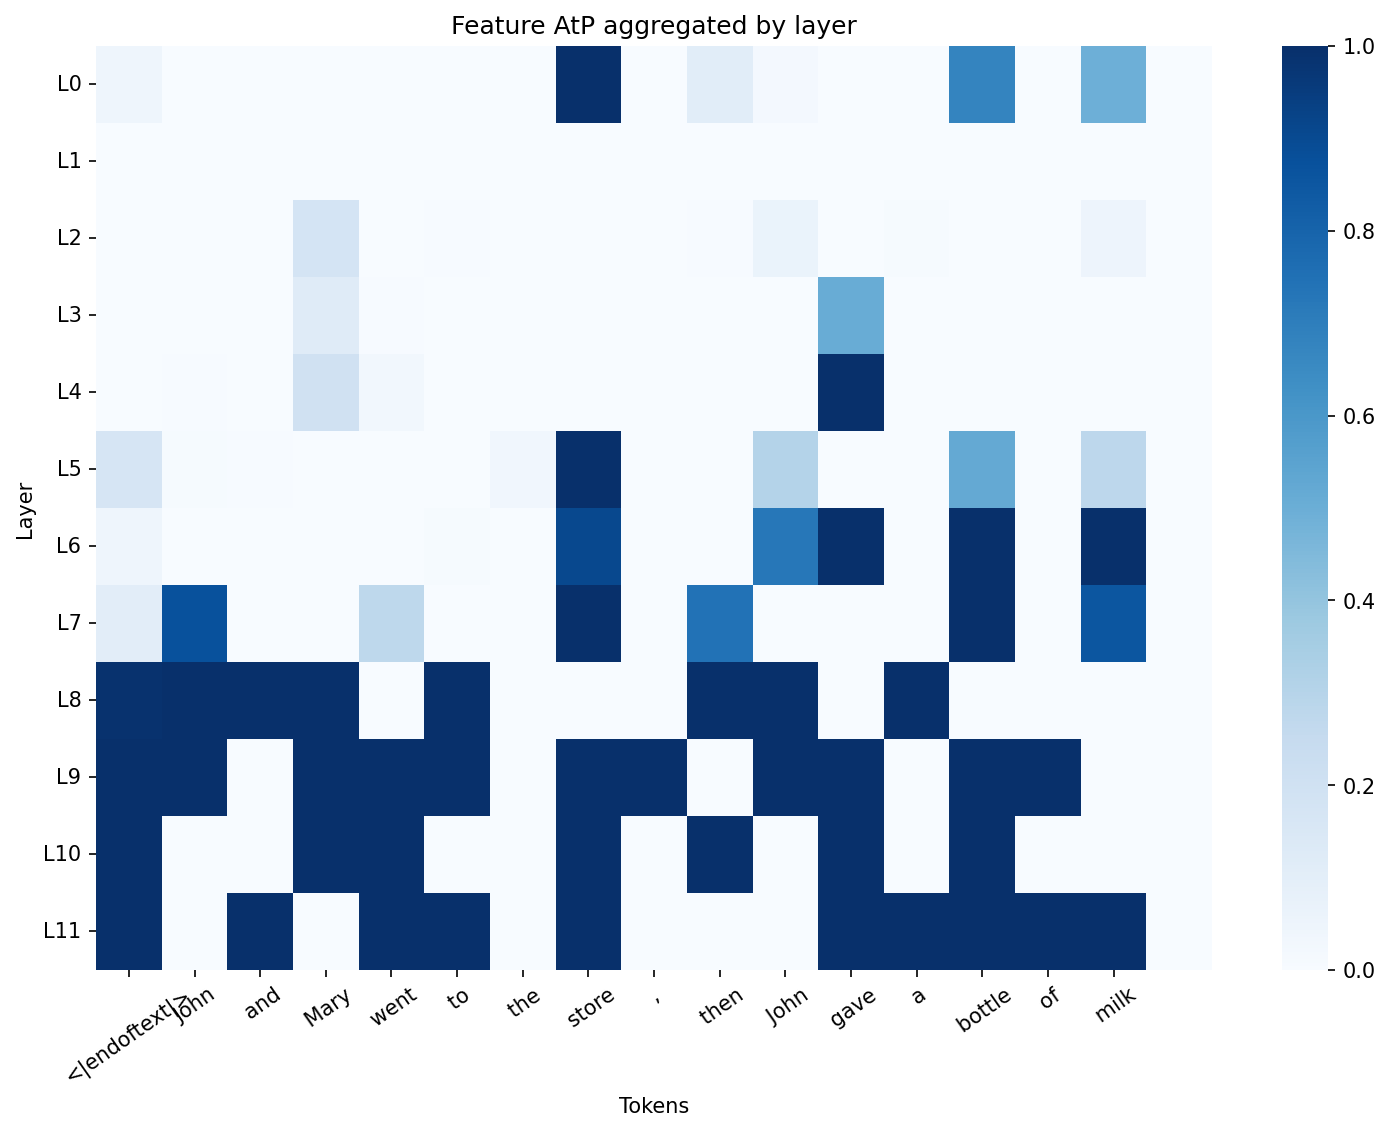

In [153]:
plt.figure(figsize=(12, 8), dpi=150)

ys = [f"L{i}" for i in range(model.cfg.n_layers)]

# Draw the heatmap
ax = sns.heatmap(patch.cpu().sum(-1), cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(ys))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(ys)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title('Feature AtP aggregated by layer')
plt.xlabel('Tokens')
plt.ylabel('Layer')

# Show the plot
plt.show()

In [170]:
def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    sae_cache[hook.name] = f_act  # Store for reference; not detach here as we need gradients
    return sae_out

def interpolate(input, baseline, steps=50):
    return [baseline + (float(i) / steps) * (input - baseline) for i in range(steps + 1)]


In [171]:
# IG
from functools import partial

# Generate baseline
baseline_tokens = torch.zeros_like(tokens)

# Interpolate between baseline and actual tokens
interpolated_inputs = interpolate(tokens, baseline_tokens, steps=50)

# Container for accumulated gradients
accumulated_grads = []

for interp_tokens in interpolated_inputs:
    # Run model forward with hooks
    out = model.run_with_hooks(
                interp_tokens,
                fwd_hooks=[
                    (
                        utils.get_act_name(component, layer_id),
                        partial(reconstr_hook, sae=saes[layer_id]),
                    ) for layer_id in range(model.cfg.n_layers)
                ]
            ).log_softmax(-1)
    
    # Target token
    ans = model.to_single_token('Mary')
    loss = -out[0, -1, ans]  # Assuming scalar output for simplification

    # Backward to get gradients on interpolated inputs
    loss.backward()

    # Collect gradients from SAE features
    for name in sae_cache:
        if sae_cache[name].grad is not None:
            if name not in accumulated_grads:
                accumulated_grads[name] = []
            accumulated_grads[name].append(sae_cache[name].grad.clone())

    # Zero all gradients for the next iteration
    model.zero_grad()

# Average the gradients across all steps
integrated_gradients = {name: torch.stack(grads).mean(0) * (tokens - baseline_tokens) for name, grads in accumulated_grads.items()}


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [23]:
json_text = """{
    "question": "What's the capital of France?",
    "answer": Paris
    }"""

non_json_text = [
    """What's the capital of France?
Paris""",
    """These are the things I love:
1. Food,
2. Sea,
3. Friends""",
    """An old man once told me: "You will succeed in life".
I hope him to be true."""
]

In [7]:
features_dict = {l: [] for l in range(model.cfg.n_layers)}

with open("json_features.txt", "r") as f:
    features = f.readlines()

for f in features:
    f = f.strip().split('-')
    layer = int(f[0])
    features_dict[layer].append(f[1])

In [26]:
features_act_dict = {
    'L': [],
    'N': [],
    'JSON Activation': [],
    'Non-JSON Activation': []
}

with torch.no_grad():
    _, json_cache = model.run_with_cache(model.to_tokens(json_text))
    _, non_json_cache = model.run_with_cache(model.to_tokens(non_json_text[2]))

for l in range(model.cfg.n_layers):
    json_activations = json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]
    non_json_activations = non_json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]

    with torch.no_grad():
        _, json_features_act, *_ = saes[l](json_activations)
        _, non_json_features_act, *_ = saes[l](non_json_activations)

    for f in features_dict[l]:
        f = int(f)
        features_act_dict['L'].append(l)
        features_act_dict['N'].append(f)
        val, ix = json_features_act[0, :, f].max(0)
        features_act_dict['JSON Activation'].append([val.item(), ix.item()])
        val, ix = non_json_features_act[0, :, f].max(0)
        features_act_dict['Non-JSON Activation'].append([val.item(), ix.item()])        

In [27]:
import pandas as pd

pd.DataFrame(features_act_dict)

,L,N,JSON Activation,Non-JSON Activation
0,0,23622,"[0.0, 0]","[0.0, 0]"
1,1,5310,"[20.185184478759766, 8]","[0.0, 0]"
2,2,10521,"[25.650108337402344, 8]","[0.0, 0]"
3,4,21672,"[3.7655177116394043, 9]","[0.0, 0]"
4,4,8148,"[1.687551736831665, 18]","[0.0, 0]"
5,6,5682,"[24.25801658630371, 23]","[0.0, 0]"
6,6,3596,"[21.313154220581055, 2]","[0.0, 0]"
7,6,13428,"[0.9894517660140991, 8]","[0.0, 0]"
8,6,2164,"[0.0, 0]","[0.0, 0]"
9,7,20690,"[25.253623962402344, 23]","[0.0, 0]"


In [21]:
list(enumerate(model.to_str_tokens(json_text)))

[(0, '<|endoftext|>'),
 (1, '{'),
 (2, '\n'),
 (3, ' '),
 (4, ' '),
 (5, ' '),
 (6, ' "'),
 (7, 'question'),
 (8, '":'),
 (9, ' "'),
 (10, 'What'),
 (11, "'s"),
 (12, ' the'),
 (13, ' capital'),
 (14, ' of'),
 (15, ' France'),
 (16, '?",'),
 (17, '\n'),
 (18, ' '),
 (19, ' '),
 (20, ' '),
 (21, ' "'),
 (22, 'answer'),
 (23, '":'),
 (24, ' Paris'),
 (25, '\n'),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' }')]